In [1]:
# import libraries
import numpy as np
import pandas as pd
import time
import math
import re

import sklearn.model_selection
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

from transformers import TokenAndPositionEmbedding, TransformerBlock

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from textwrap import wrap
import seaborn as sns

In [85]:
model_seq = keras.models.load_model("final_models/M1_seq")

In [206]:
model_quant = keras.models.load_model("final_models/M2_seq_nsaf")

In [317]:
model_aaindex_raw = keras.models.load_model("final_models/M7_seq_aaindex1_raw")

In [323]:
model_aaindex_FS = keras.models.load_model("final_models/M7_seq_aaindex1")

In [324]:
model_combined_raw = keras.models.load_model("final_models/M7_seq_nsaf_aaindex1_raw")

In [325]:
model_combined_FS = keras.models.load_model("final_models/M8_seq_nsaf_aaindex1_var_corr05_REDO")

In [2]:
model_seq = keras.models.load_model("final_models/M8_seq_combSpC_aaindex1_var_corr05_REDO")

In [99]:
model_seq_spc = keras.models.load_model("final_models/M2_seq_combined_quant")

In [3]:
# integer-encode peptides
maxLength = 40

aaDict = {"-": 0, "A": 1, "R": 2, "N": 3, "D": 4, "C": 5, "Q": 6, "E": 7, "G": 8, "H": 9, "I": 10, "L": 11, 
          "K": 12, "M": 13, "F": 14, "P": 15, "S": 16, "T": 17, "W": 18, "Y": 19, "V": 20, "U": 21}

def convertPeptide(peptide, maxLength):
    j = 0
    hotPeptide = []
    for aa in peptide:
        hotPeptide.append(aaDict[aa])
        j = j + 1
    for k in range(maxLength - j):
        hotPeptide.append(0)

    return np.array(hotPeptide)

## check model works as expected

In [9]:
df = pd.read_table('final_data/M1_PRED_seq_134b_200epoch.tsv')
df.head()

,Peptide,Detectability,Predictions
0,GYSLASLLAK,1,0.772385
1,LTSSNEINK,0,0.450480
2,ACTIAIR,0,0.363180
3,VGPVPVLVMSLLFIASVFMLHIWGK,0,0.006660
4,TLEEDVDDR,0,0.288882


In [14]:
test_predictions = model_seq.predict([np.array([convertPeptide(pep, maxLength) for pep in df['Peptide']]), np.asarray([1]*df.shape[0])], 
                                     verbose=1)

710/710 [==============================] - 2s 3ms/step


In [15]:
df["Predictions"] = test_predictions[0].flatten()
df.head()

,Peptide,Detectability,Predictions,Pred2
0,GYSLASLLAK,1,0.772385,0.772385
1,LTSSNEINK,0,0.450480,0.450480
2,ACTIAIR,0,0.363180,0.363180
3,VGPVPVLVMSLLFIASVFMLHIWGK,0,0.006660,0.006660
4,TLEEDVDDR,0,0.288882,0.288882


In [136]:
df['Predictions'].mean()

0.5279104910840215

## Do on mouse dataset

### Pre-processing

In [2]:
# import detected and undetected datasets
detected_peptides = pd.read_table('../data/detected_peptides_SpC_aaindex1_PXD027822.tsv')
undetected_peptides = pd.read_table('../data/undetected_peptides_SpC_aaindex1_PXD027822.tsv')

In [10]:
undetected_peptides.shape

(56964, 572)

In [3]:
detected_peptides.describe(include='all')

,Peptide,SAF,NSAF,CBN_P,CBN_S,RSc,ANDN920101,ARGP820101,ARGP820102,ARGP820103,...,KARS160113,KARS160114,KARS160115,KARS160116,KARS160117,KARS160118,KARS160119,KARS160120,KARS160121,KARS160122
count,6750,6750.000000,6750.000000,6750.000000,6750.000000,6750.000000,6750.000000,6750.000000,6750.000000,6750.000000,...,6750.000000,6750.000000,6750.000000,6750.000000,6750.000000,6750.000000,6750.000000,6750.000000,6750.000000,6750.000000
unique,6750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,YESSTASALVA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.017169,0.000985,0.001944,0.001539,-10.125552,4.326488,0.918413,1.040808,1.091948,...,10.555822,16.068996,11.569626,19.385269,30.548764,6.005895,23.175662,-0.407711,9.408114,3.300184
std,NaN,0.017490,0.001004,0.001755,0.001755,1.448449,0.072794,0.205929,0.249749,0.223783,...,1.417854,1.949337,1.465563,2.443848,3.727286,0.262591,1.906466,0.310292,0.665062,0.799210
min,NaN,0.000153,0.000009,0.000639,0.000234,-12.478348,4.069091,0.208182,0.252500,0.358000,...,5.363636,7.188000,5.454545,8.461538,13.000000,4.433333,11.334077,-2.085706,5.589769,0.323077
25%,NaN,0.005625,0.000323,0.000872,0.000467,-11.255619,4.278000,0.775000,0.865385,0.937273,...,9.600000,14.781355,10.588235,17.727273,28.100700,5.852319,21.966438,-0.588731,8.985363,2.737567
50%,NaN,0.011842,0.000680,0.001340,0.000935,-10.155409,4.326154,0.910742,1.024495,1.076667,...,10.545455,16.033500,11.555556,19.333333,30.500875,6.033000,23.314000,-0.367167,9.450028,3.242470
75%,NaN,0.022330,0.001281,0.002391,0.001986,-9.016386,4.374200,1.047467,1.195000,1.232342,...,11.454545,17.345969,12.545455,21.000000,33.000000,6.190833,24.558591,-0.165455,9.876105,3.806896


In [12]:
detected_peptides['Peptide'].str.len().describe()

count    6750.000000
mean       12.421630
std         3.880685
min         7.000000
25%        10.000000
50%        11.000000
75%        14.000000
max        35.000000
Name: Peptide, dtype: float64

In [5]:
print(detected_peptides.shape)
print(undetected_peptides.shape)

(6750, 572)
(56964, 572)


In [6]:
# keep detected and undetected peptides less than or equal to 40 aa AND greater than or equal to 7 aa in length
detected_peptides = detected_peptides.loc[(detected_peptides["Peptide"].str.len()>=7) & 
                                          (detected_peptides["Peptide"].str.len()<=40)].reset_index(drop=True)

undetected_peptides = undetected_peptides.loc[(undetected_peptides["Peptide"].str.len()>=7) & 
                                              (undetected_peptides["Peptide"].str.len()<=40)].reset_index(drop=True)

print(detected_peptides.shape)
print(undetected_peptides.shape)

(6750, 572)
(56008, 572)


In [7]:
# double check 0 peptides in undetected peptides are present in detected peptides
print(len(undetected_peptides[undetected_peptides["Peptide"].isin(detected_peptides["Peptide"])]))

# add detectability column
detected_peptides.insert(loc=1, column='Detectability', value=1)
undetected_peptides.insert(loc=1, column='Detectability', value=0)

print(detected_peptides.shape)
print(undetected_peptides.shape)

0
(6750, 573)
(56008, 573)


In [104]:
# # remove any rows with nan values
# detected_peptides = detected_peptides.dropna(axis=1, how='any')
# undetected_peptides = undetected_peptides.dropna(axis=1, how='any')

# print(detected_peptides.shape)
# print(undetected_peptides.shape)

In [8]:
# take random sample of undetected_peptides, with equal number of rows to detected_peptides
# random_state is used for reproducibility
undetected_peptides_balanced = undetected_peptides.sample(n=detected_peptides.shape[0], 
                                                         random_state=42).reset_index(drop=True)
print(detected_peptides.shape)
print(undetected_peptides_balanced.shape)

(6750, 573)
(6750, 573)


In [9]:
all_peptides = pd.concat([detected_peptides, undetected_peptides_balanced])
peptides_df = all_peptides.sample(frac=1, random_state=1).reset_index(drop=True)
print(peptides_df.shape)

(13500, 573)


In [10]:
peptides_df.head()

,Peptide,Detectability,SAF,NSAF,CBN_P,CBN_S,RSc,ANDN920101,ARGP820101,ARGP820102,...,KARS160113,KARS160114,KARS160115,KARS160116,KARS160117,KARS160118,KARS160119,KARS160120,KARS160121,KARS160122
0,DYETATLSEIK,1,0.006726,0.000386,0.001223,0.000818,-10.362028,4.360909,0.812727,0.839091,...,10.363636,16.910000,12.000000,21.000000,32.272727,6.241818,24.235182,-1.021273,9.635455,3.097273
1,SPQPPVEEEDEHFDDTVVCLDTYNCDLHFK,0,0.006250,0.000359,0.001106,0.000701,-10.603205,4.454333,0.923000,0.834667,...,11.200000,17.293900,12.700000,20.900000,34.034267,6.412000,26.159200,-0.435367,10.463000,4.248033
2,ALLELQLEPEELYQTFQR,1,0.045455,0.002608,0.005078,0.004673,-7.753111,4.327778,0.924444,1.337778,...,12.388889,18.798611,13.611111,22.111111,35.500000,6.155556,25.662722,-0.288167,10.225389,3.012500
3,QYIFEYDSSDR,0,0.000362,0.000021,0.000639,0.000234,-12.478348,4.488182,0.917273,0.660000,...,13.181818,20.680091,14.454545,26.000000,38.727273,6.442727,25.955545,-0.323727,10.546545,3.127818
4,ESAAHDYTLR,0,0.013491,0.000774,0.001457,0.001051,-9.974668,4.438000,0.687000,0.846000,...,11.200000,17.305400,12.400000,21.700000,32.500000,6.012000,22.604300,-0.692100,9.362300,2.730800


In [11]:
test_peptide = peptides_df.filter(['Peptide'], axis=1)

In [12]:
test_saf = peptides_df.filter(['SAF'], axis=1)
test_nsaf = peptides_df.filter(['NSAF'], axis=1)
test_CBN_P = peptides_df.filter(['CBN_P'], axis=1)
test_CBN_S = peptides_df.filter(['CBN_S'], axis=1)
test_RSc = peptides_df.filter(['RSc'], axis=1)
test_SpC = peptides_df.iloc[:, 2:7]

In [13]:
test_aaindex = peptides_df.iloc[:, 7:]

In [14]:
all_peptides = peptides_df.filter(['Peptide','Detectability'], axis=1)

In [34]:
all_peptides

,Peptide,Detectability
0,DYETATLSEIK,1
1,SPQPPVEEEDEHFDDTVVCLDTYNCDLHFK,0
2,ALLELQLEPEELYQTFQR,1
3,QYIFEYDSSDR,0
4,ESAAHDYTLR,0
...,...,...
13495,DNFHGLAIFLDTYPNDETTER,1
13496,STTLDAGNIK,1
13497,TTQIGCLLR,0
13498,AIFLFVDK,1


In [16]:
test_aaindex = test_aaindex.dropna(axis=1, how='any')
test_aaindex.shape

(13500, 553)

In [114]:
# print(model_combined_FS.summary())

In [280]:
# seq predictions
test_predictions = model_seq.predict([np.array([convertPeptide(pep, maxLength) for pep in all_peptides['Peptide']]), 
                                      np.asarray([1]*all_peptides.shape[0])], verbose=1)

420/420 [==============================] - 1s 4ms/step


In [286]:
# quant predictions
test_predictions = model_quant.predict([np.array([convertPeptide(pep, maxLength) for pep in all_peptides['Peptide']]), 
                                        np.asanyarray(test_nsaf)], verbose=1)

420/420 [==============================] - 2s 4ms/step


In [291]:
# aaindex1 (raw) predictions
test_predictions = model_aaindex_raw.predict([np.array([convertPeptide(pep, maxLength) for pep in all_peptides['Peptide']]), 
                                              np.asanyarray(test_aaindex)], verbose=1)

420/420 [==============================] - 2s 4ms/step


In [415]:
# aaindex1 (feature-selected) predictions
test_predictions = model_aaindex_FS.predict([np.array([convertPeptide(pep, maxLength) for pep in all_peptides['Peptide']]), 
                                             np.asanyarray(test_aaindex_corr)], verbose=1)

420/420 [==============================] - 1s 3ms/step


In [419]:
# combined (raw) predictions
test_predictions = model_combined_raw.predict([np.array([convertPeptide(pep, maxLength) for pep in all_peptides['Peptide']]), 
                                               np.asanyarray(test_nsaf), np.asanyarray(test_aaindex)], verbose=1)

420/420 [==============================] - 1s 3ms/step


In [115]:
# seq + combined SpC predictions
test_predictions = model_seq_spc.predict([np.array([convertPeptide(pep, maxLength) for pep in all_peptides['Peptide']]), 
                                              np.asanyarray(test_SpC)], verbose=1)

422/422 [==============================] - 1s 3ms/step


In [31]:
# seq + combined SpC + AAIndex1 FS predictions
test_predictions = model_seq.predict([np.array([convertPeptide(pep, maxLength) for pep in all_peptides['Peptide']]), 
                                      np.asanyarray(test_SpC) , np.asanyarray(test_aaindex_corr)], verbose=1)

422/422 [==============================] - 1s 3ms/step


In [193]:
model = keras.models.load_model("final_models/M2_seq_combined_quant")

In [196]:
# run predictions here
test_predictions = model.predict([np.array([convertPeptide(pep, maxLength) for pep in all_peptides['Peptide']]), 
                                  np.asanyarray(test_SpC)], verbose=1)

422/422 [==============================] - 1s 3ms/step


In [ ]:
#all_peptides = pd.read_table('final_data/PRED_ALL_MOUSE_label-free.tsv')

In [32]:
test_predictions

[array([[0.51002735],
        [0.02071285],
        [0.9770006 ],
        ...,
        [0.46429342],
        [0.7913041 ],
        [0.7138719 ]], dtype=float32),
 array([[0.64625514],
        [0.27400273],
        [0.8367776 ],
        ...,
        [0.58372545],
        [0.6920253 ],
        [0.8030518 ]], dtype=float32)]

In [36]:
all_peptides['Pred'] = test_predictions[0].flatten()
all_peptides

,Peptide,Detectability,Pred
0,DYETATLSEIK,1,0.510027
1,SPQPPVEEEDEHFDDTVVCLDTYNCDLHFK,0,0.020713
2,ALLELQLEPEELYQTFQR,1,0.977001
3,QYIFEYDSSDR,0,0.087815
4,ESAAHDYTLR,0,0.608355
...,...,...,...
13495,DNFHGLAIFLDTYPNDETTER,1,0.471024
13496,STTLDAGNIK,1,0.226291
13497,TTQIGCLLR,0,0.464293
13498,AIFLFVDK,1,0.791304


In [44]:
all_peptides.to_csv('final_data/MOUSE_PRED_combSpC_AAIndex_FS_label-free.tsv', sep='\t', index=False)

In [198]:
#mouse_quant = all_peptides[['Peptide', 'Detectability']]
mouse_quant['SpC_pred'] = test_predictions[0].flatten()
mouse_quant

,Peptide,Detectability,SAF_pred,NSAF_pred,CBN_P_pred,CBN_S_pred,RSc_pred,SpC_pred
0,DYETATLSEIK,1,0.503201,0.925684,0.917773,0.903479,0.920984,0.496799
1,SPQPPVEEEDEHFDDTVVCLDTYNCDLHFK,0,0.032167,0.512066,0.509957,0.410994,0.480479,0.010143
2,ALLELQLEPEELYQTFQR,1,0.961572,0.999779,0.985444,0.984939,0.981141,0.976854
3,QYIFEYDSSDR,0,0.039714,0.184867,0.799652,0.676138,0.695421,0.053617
4,ESAAHDYTLR,0,0.573598,0.972133,0.914184,0.933903,0.871141,0.496248
...,...,...,...,...,...,...,...,...
13495,DNFHGLAIFLDTYPNDETTER,1,0.483379,0.915715,0.791066,0.763400,0.833973,0.158779
13496,STTLDAGNIK,1,0.060645,0.617729,0.821742,0.802687,0.784374,0.079027
13497,TTQIGCLLR,0,0.320897,0.918327,0.874723,0.897231,0.903793,0.353901
13498,AIFLFVDK,1,0.580545,0.969093,0.923773,0.807694,0.794759,0.809407


In [207]:
mouse_quant.to_csv('final_data/QUANT_PRED_ALL_MOUSE_label-free.tsv', sep='\t', index=False)

In [134]:
all_peptides["SAF_FS_predictions"] = test_predictions[0].flatten()
all_peptides

,Peptide,Detectability,Combined_SpC_predictions,SAF_FS_predictions
0,DYETATLSEIK,1,0.496799,0.358046
1,SPQPPVEEEDEHFDDTVVCLDTYNCDLHFK,0,0.010143,0.014375
2,ALLELQLEPEELYQTFQR,1,0.976854,0.976880
3,QYIFEYDSSDR,0,0.053617,0.020142
4,ESAAHDYTLR,0,0.496248,0.648893
...,...,...,...,...
13495,DNFHGLAIFLDTYPNDETTER,1,0.158779,0.279486
13496,STTLDAGNIK,1,0.079027,0.055478
13497,TTQIGCLLR,0,0.353901,0.324410
13498,AIFLFVDK,1,0.809407,0.557287


In [427]:
# all_peptides["Combined_SpC_predictions"] = test_predictions[0].flatten()
# all_peptides

,Peptide,Detectability,Seq_predictions,Quant_predictions,AAIndex_raw_predictions,AAIndex_FS_predictions,Combined_raw_predictions,Combined_FS_predictions
0,NEVAALTAAGK,1,0.570341,0.528765,0.682860,0.528352,0.570152,0.461659
1,VAALQNLVK,1,0.812481,0.783651,0.858978,0.848527,0.856152,0.884793
2,GYFDQILNSILLDPSDDTK,0,0.863777,0.280564,0.776009,0.837055,0.877898,0.296408
3,LFPSGLDQK,1,0.673111,0.861979,0.704770,0.639877,0.853641,0.827468
4,AVEEVTVEK,0,0.841739,0.726466,0.823689,0.800058,0.819957,0.697454
...,...,...,...,...,...,...,...,...
13421,DNHFAIFIIPQGR,1,0.449476,0.051267,0.233233,0.336474,0.113684,0.144230
13422,SVPSWFVR,1,0.394494,0.495562,0.351752,0.332669,0.495894,0.557914
13423,CPQIEEAVIQSGSK,0,0.318714,0.017445,0.404059,0.245825,0.184775,0.012072
13424,AIFQAIAAK,1,0.876487,0.836715,0.918013,0.858032,0.806467,0.899614


In [157]:
for pred in all_peptides["Predictions"]:
    new_pred = []
    pred_rounded = np.where(pred > 0.5, 1, 0)
    new_pred.append(pred_rounded)
new_pred

[array(1)]

In [435]:
# all_peptides["Pred_mean_round"] = np.where(all_peptides["Predictions"] > all_peptides["Predictions"].mean(), 1, 0)
# all_peptides

In [436]:
all_peptides.to_csv('final_data/PRED_ALL_MOUSE_label-free.tsv', sep='\t', index=False)

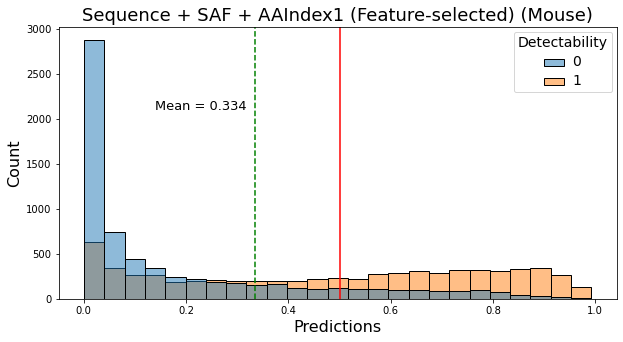

In [137]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=all_peptides, x=all_peptides['SAF_FS_predictions'], hue=all_peptides['Detectability'], stat='count', bins=25)
ax.set_title('Sequence + SAF + AAIndex1 (Feature-selected) (Mouse)', fontsize=18)
ax.set_xlabel('Predictions', fontsize=16)
ax.set_ylabel('Count', fontsize=16)

plt.axvline(x=all_peptides['Detectability'].mean(), color='r')
plt.axvline(x=all_peptides['SAF_FS_predictions'].mean(), color='g', ls='--')
plt.text(0.14,2100, ('Mean = {:.3f}'.format(all_peptides['SAF_FS_predictions'].mean())), fontsize=13)

plt.setp(ax.get_legend().get_texts(), fontsize=14)
plt.setp(ax.get_legend().get_title(), fontsize=14)
#plt.savefig('final_figures/MOUSE_label-free_SAF_FS_model_hist.png', dpi=200)

In [37]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = sklearn.metrics.confusion_matrix(all_peptides['Detectability'], 
                                                    np.rint(all_peptides['Pred']))
confusion_matrix

array([[5610, 1140],
       [3199, 3551]], dtype=int64)

In [38]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(all_peptides['Detectability'], np.rint(all_peptides['Pred']))

0.6785925925925926

In [39]:
# Recall
from sklearn.metrics import recall_score
recall_score(all_peptides['Detectability'], np.rint(all_peptides['Pred']), average='binary')

0.526074074074074

In [40]:
# Precision
from sklearn.metrics import precision_score
precision_score(all_peptides['Detectability'], np.rint(all_peptides['Pred']), average='binary')

0.7569814538477937

In [41]:
# F1 score
from sklearn.metrics import f1_score
f1_score(all_peptides['Detectability'], np.rint(all_peptides['Pred']), average='binary')

0.6207499344462897

In [42]:
# MCC (Matthew's correlation coefficient)
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(all_peptides['Detectability'], np.rint(all_peptides['Pred']))

0.3750603796630805

## Pre-processing

In [125]:
peptides_df.iloc[:, 7:]

,ANDN920101,ARGP820101,ARGP820102,ARGP820103,BEGF750101,BEGF750102,BEGF750103,BHAR880101,BIGC670101,BIOV880101,...,KARS160113,KARS160114,KARS160115,KARS160116,KARS160117,KARS160118,KARS160119,KARS160120,KARS160121,KARS160122
0,4.360909,0.812727,0.839091,0.929091,0.627273,0.720000,0.657273,0.451818,83.000000,-19.272727,...,10.363636,16.910000,12.000000,21.000000,32.272727,6.241818,24.235182,-1.021273,9.635455,3.097273
1,4.454333,0.923000,0.834667,0.817333,0.511333,0.716000,0.727667,0.438700,83.103333,7.266667,...,11.200000,17.293900,12.700000,20.900000,34.034267,6.412000,26.159200,-0.435367,10.463000,4.248033
2,4.327778,0.924444,1.337778,1.305000,0.683333,0.732778,0.610556,0.436944,91.916667,11.777778,...,12.388889,18.798611,13.611111,22.111111,35.500000,6.155556,25.662722,-0.288167,10.225389,3.012500
3,4.488182,0.917273,0.660000,0.740909,0.498182,0.728182,0.746364,0.470091,88.945455,-9.000000,...,13.181818,20.680091,14.454545,26.000000,38.727273,6.442727,25.955545,-0.323727,10.546545,3.127818
4,4.438000,0.687000,0.846000,0.956000,0.652000,0.733000,0.679000,0.431000,80.360000,-8.200000,...,11.200000,17.305400,12.400000,21.700000,32.500000,6.012000,22.604300,-0.692100,9.362300,2.730800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13495,4.447143,0.839524,0.881429,0.957143,0.557143,0.742381,0.732857,0.442238,83.480952,6.047619,...,11.666667,17.072571,12.619048,20.333333,33.619714,5.931429,24.664000,-0.810286,9.863000,3.314571
13496,4.351000,0.625000,0.934000,0.997000,0.570000,0.719000,0.727000,0.456300,73.940000,-14.000000,...,8.500000,13.623000,9.900000,16.700000,25.900700,5.920000,21.558100,-1.027400,8.593400,3.182700
13497,4.262222,0.791111,1.432222,1.351111,0.553333,0.782222,0.691111,0.443556,83.533333,41.888889,...,9.555556,16.042333,11.111111,19.111111,29.222222,5.903333,23.188333,-1.121667,9.200000,3.738667
13498,4.357500,1.416250,1.371250,1.456250,0.723750,0.840000,0.552500,0.396875,92.875000,74.250000,...,12.000000,16.887500,12.750000,19.125000,32.875875,6.121250,23.902625,-0.227500,9.845875,2.609875


In [24]:
test_aaindex.shape

(13500, 553)

In [25]:
# apply variance threshold
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.005).fit(test_aaindex)
mask = selector.get_support()

test_aaindex_var = test_aaindex.loc[:, mask]

print(test_aaindex_var.shape)

(13500, 453)


In [26]:
test_aaindex_corr = test_aaindex_var.corr()

In [27]:
test_aaindex_var.shape

(13500, 453)

In [28]:
correlated_features = set()
for i in range(len(test_aaindex_corr.columns)):
    for j in range(i):
        if abs(test_aaindex_corr.iloc[i, j]) > 0.505:
            colname = test_aaindex_corr.columns[i]
            correlated_features.add(colname)

len(correlated_features)

449

In [29]:
test_aaindex_corr = test_aaindex_var
test_aaindex_corr.drop(labels=correlated_features, axis=1, inplace=True)
test_aaindex_corr

D:\Users\Anima\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,ANDN920101,ARGP820101,ARGP820102,WERD780103
0,4.360909,0.812727,0.839091,0.091818
1,4.454333,0.923000,0.834667,0.083333
2,4.327778,0.924444,1.337778,0.123333
3,4.488182,0.917273,0.660000,0.100909
4,4.438000,0.687000,0.846000,0.026000
...,...,...,...,...
13495,4.447143,0.839524,0.881429,0.215714
13496,4.351000,0.625000,0.934000,0.159000
13497,4.262222,0.791111,1.432222,0.048889
13498,4.357500,1.416250,1.371250,0.266250
